## Strand Design PCR Simulator: 

This notebook has a simple tag constructor that allows both strands to be represented. Primer elongation takes place along distinct strands, allowing us to model strand assymetry. This allows us to build a simulation for the first few PCR cycles using various tag assemblies. This simulation clearly shows that strand assymetry generates 4 distinct tag species that correspond to the 4 strands of each locus in a somatic genome. 

We started with the design from the Hong et al paper from 2017 (BioTechniques 63:221-226 (November 2017) doi 10.2144/000114608): and then we modified it to make it give full duplex tagging.

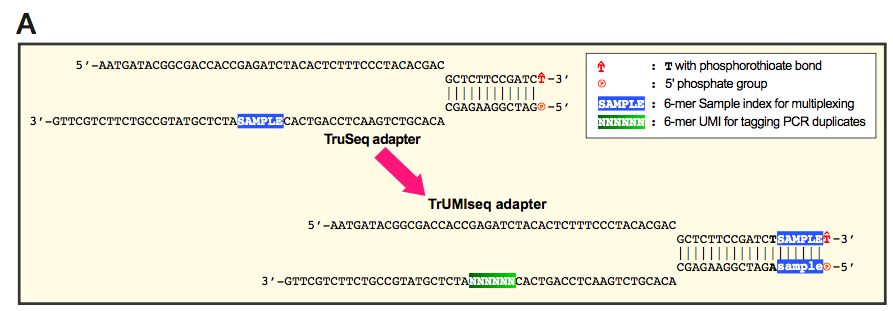

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

img_path="hong_umi.png"
Image(filename = img_path)#, width=400, height=100)

In [4]:
import os, sys, random
from importlib import reload

sys.path.append('src/')
import Probe.MolBio as MB
import Thermo.SWThermo as SWT
reload(SWT)

def random_base(b):
    degen={'A':'A',
            'C':'C',
            'G':'G',
            'T':'T',
            'U':['T'],
            'R':['a','g'],
            'Y':['c','t'],
            'S':['g','c'],
            'W':['a','t'],
            'K':['g','t'],
            'M':['a','c'],
            'B':['c','g','t'],
            'D':['a','g','t'],
            'H':['a','c','t'],
            'V':['a','c','g'],
            'N':['a','c','g','t']}
    b=b.upper()
    if b in ['G', 'A', 'T', 'C']:return b
    return random.choice(degen[b])

def make_seq_lst(s):
    """Properly converts sequences, N's and mismatch sequences into Segment input(which is a base list)"""
    if not(' ' in s) and not('/' in s):
        return list(s)
    lst=[]
    while '  ' in s:
        s=s.replace('  ', ' ')
    for x in s.split(' '):
        if '/' in x:
            lst.append(x)
        else:
            lst.extend(list(x))
    return lst

class Segment:
    """
    This is a construct segment like a primer or section of dsDNA
    it stores both strands independedntly and correctly elongate on either strand
    """
    def __init__(self, seqLst, name):
        self.name=name
        if type(seqLst)==type(''):
            seqLst=make_seq_lst(seqLst)
        self.seqLst=seqLst#Actually a base list
        self.n=0
        self.process()
    def process(self):
        self.senseLst=[];self.complementLst=[]
        for b in self.seqLst:
            if b.upper() in ['G', 'A', 'T', 'C']:
                s=b
                c=MB.Antisense(b)
            elif len(b)==1:
                s=random_base(b)
                c=MB.Antisense(s)
            elif len(b)==3 and '/' in b:
                s,c=b.split('/')
            else:
                raise('Not Supported: %s'%str(self.seqLst))
            self.senseLst.append(s)
            self.complementLst.append(c)
        self.n=len(self.senseLst)
    def sense(self):
        return ''.join(self.senseLst)
    def complement(self):
        return ''.join(self.complementLst)
    def antisense(self):
        return ''.join([self.complementLst[i] for i in range(self.n-1, -1,-1)])
    def For_Prime(self, primer):
        """
        This function sees if a seqment (usually a primer) can prime over this segment.
        """
        subj_seq=self.antisense()
        primer_seq=primer.sense()
        r=SWT.TM.SWTm_WillItPCR_primer(subj_seq, primer_seq, DNAConc=None)
        if r and 'TmAB' in r and r['TmAB']>60.0:
            print('For_HIT!!!', r)
            print(r['match_str'])
            subj_hit, p_hit = r['hit']
            primer_endpoint = primer_seq.find(MB.Antisense(p_hit))+len(p_hit)
            if primer_endpoint!=len(primer_seq):
                print("For_misprime", primer_seq, self.antisense(), p_hit)
                return False
            subj_seq=self.sense()
            subj_endpoint=subj_seq.find(subj_hit)+len(subj_hit)
            tail=subj_seq[subj_endpoint+1:]
            if tail:
                if not('_RevPRIMED_' in self.name):
                    name='%s_RevPRIMED_%s'%(primer.name, self.name)
                else:
                    name = self.name
            else:
                name=self.name
                if name.endswith('__rev'):
                    name=name[:-5]
            return Segment(list(primer_seq+MB.Antisense(tail)), name)
        return False
    def Rev_Prime(self, primer):
        """
        This function sees if a seqment (usually a primer) can prime over this segment.
        """
        amplicon_seq=self.sense()
        primer_seq=primer.sense()
        r=SWT.TM.SWTm_WillItPCR_primer(amplicon_seq, primer_seq, DNAConc=None)
        if r and 'TmAB' in r and r['TmAB']>60.0:#This is just a stub!!!
            print('Rev_HIT!!!', r)
            print(r['match_str'])
            subj_hit, p_hit = r['hit']
            primer_endpoint = primer_seq.find(MB.Antisense(p_hit))+len(p_hit)
            if primer_endpoint!=len(primer_seq):
                print("Rev misprime", primer_seq, self.sense(), p_hit)
                return False
            subj_endpoint=amplicon_seq.find(subj_hit)+len(subj_hit)
            tail=amplicon_seq[subj_endpoint:]
            if tail:
                if not('_RevPRIMED_' in self.name):
                    name='%s_RevPRIMED_%s'%(primer.name, self.name)
                else:
                    name=self.name
            else:
                name=primer.name
                if not(name.endswith('__rev')):
                    name=name+'__rev'
            return Segment(list(primer_seq+MB.Antisense(tail)), name)
        return False
    def __str__(self):
        return '%s[n=%i]'%(self.name, self.n)
    
        
        
class Strand:
    """Represents a single ds DNA molecule. ('Strand' is a bit of a misnomer)"""
    def __init__(self, segmentLst, name='', upper=True):
        self.upper=upper
        self.name=name
        self.segmentLst=segmentLst
        self.n=len(self.segmentLst)
    def representative_seq(self):
        if self.upper:
            return self.sense_strand()#+ '_u'
        else:
            return self.antisense_strand()#+ '_l'
    def sense_strand(self):
        return '-'.join([s.sense() for s in self.segmentLst])
    def complement_strand(self):
        return '-'.join([s.complement() for s in self.segmentLst])
    def antisense_strand(self):
        l=[s.antisense() for s in self.segmentLst]
        l.reverse()
        return '-'.join(l)
    def elongate_forward_primer(self, primer_segment):
        """Currently limited, It cannot prime across a segment boundary"""
        for i in range(self.n):
            seg=self.segmentLst[i].For_Prime(primer_segment)
            if seg:
                elongation_segLst=[Segment(MB.Antisense(s.antisense()), s.name) for s in self.segmentLst[i+1:]]
                return Strand([seg]+elongation_segLst, name=self.name, upper=self.upper)
    def elongate_reverse_primer(self, primer_segment):
        """Currently limited, It cannot prime across a segment boundary"""
        for i in range(self.n-1, -1,-1):
            primed_segment=self.segmentLst[i].Rev_Prime(primer_segment)
            if primed_segment:
                sLst=[primed_segment]
                for ii in range(i-1,-1,-1):
                    s=self.segmentLst[ii]
                    sLst.append(Segment(MB.Antisense(s.sense()), s.name))
                return Strand(sLst, name=self.name, upper=not(self.upper))
    def __len__(self):
        l = 0
        for s in self.segmentLst:
            l+=s.n
        return l
    def display_double_stranded(self):
        match_lst=[]
        upper_strnd=self.sense_strand()
        lower_strnd=self.complement_strand()
        for i in range(len(upper_strnd)):
            if upper_strnd[i]=='-':
                match_lst.append(' ')
                continue
            if upper_strnd[i]==MB.Antisense(lower_strnd[i]):
                match_lst.append('|')
            else:
                match_lst.append('x')
        print(upper_strnd)
        print(''.join(match_lst))
        print(lower_strnd)
    def __str__(self):
        l=[str(s) for s in self.segmentLst]
        return '|'.join(l) + ' total_len:%i'%len(self)
                
        
def AmplifyRound(Pool, for_primer, rev_primer):
    """Does a single amplification on pool of dsDNA fragments"""
    outPool=[];failLst=[]
    for strand in Pool:
        success=False
        e = strand.elongate_forward_primer(for_primer)
        if e:
            outPool.append(e)
            success=True
        else:
            e=strand.elongate_reverse_primer(for_primer)
            if e:
                outPool.append(e)
                success=True
        e= strand.elongate_reverse_primer(rev_primer)
        if e:
            outPool.append(e)
            success=True
        else:
            e= strand.elongate_forward_primer(rev_primer)
            if e:
                outPool.append(e)
                success=True
        if not(success):failLst.append(strand)
    return outPool, failLst

### Constructor

In [5]:
#Build Constructs:
Illumina_pcr1=Segment(list('AATGATACGGCGACCACCGAGATCTACAC'), 'illumina_PCR1_for')
Illumina_pcr2=Segment(list('CAAGCAGAAGACGGCATACGAGAT'), 'illumina_PCR2_rev')

sLst1 = [
    Segment('AATGATACGGCGACCACCGAGATCTACAC', 'illumina_PCR1_site'),
    Segment('T/G A/C', 'assym_f'),
    Segment('NNNNNN', 'UMI_f'),
    Segment('CCCCCCCGCCCCCCC', 'GenomicInsert'),
    Segment('NNNNNN', 'UMI_top'),
    Segment('T/G A/C', 'assym_r'),
    Segment(MB.Antisense('CAAGCAGAAGACGGCATACGAGAT'), 'illumina_PCR2rev_site')
]
sLst2 = [
    Segment('AATGATACGGCGACCACCGAGATCTACAC', 'illumina_PCR1_site'),
    Segment('T/G A/C', 'assym_f'),
    Segment('NNNNNN', 'UMI_f'),
    Segment(make_seq_lst('CCCCCCCACCCCCCC'), 'GenomicInsert'),
    Segment('NNNNNN', 'UMI_top'),
    Segment('T/G A/C', 'assym_r'),
    Segment(MB.Antisense('CAAGCAGAAGACGGCATACGAGAT'), 'illumina_PCR2rev_site')
]

pool=[Strand(sLst1, name='cpy1'), Strand(sLst2, name='cpy2')]

print('Pool:')
for s in pool:
    s.display_double_stranded()
    print('\n')

Pool:
AATGATACGGCGACCACCGAGATCTACAC-TA-tctttg-CCCCCCCGCCCCCCC-ccggcg-TA-ATCTCGTATGCCGTCTTCTGCTTG
||||||||||||||||||||||||||||| xx |||||| ||||||||||||||| |||||| xx ||||||||||||||||||||||||
TTACTATGCCGCTGGTGGCTCTAGATGTG-GC-agaaac-GGGGGGGCGGGGGGG-ggccgc-GC-TAGAGCATACGGCAGAAGACGAAC


AATGATACGGCGACCACCGAGATCTACAC-TA-ctgagc-CCCCCCCACCCCCCC-tatttc-TA-ATCTCGTATGCCGTCTTCTGCTTG
||||||||||||||||||||||||||||| xx |||||| ||||||||||||||| |||||| xx ||||||||||||||||||||||||
TTACTATGCCGCTGGTGGCTCTAGATGTG-GC-gactcg-GGGGGGGTGGGGGGG-ataaag-GC-TAGAGCATACGGCAGAAGACGAAC




### PCR Simulator:

In [6]:
#SimulatePCR
failLst=[]
for i in range(4): 
    pool, fail=AmplifyRound(pool, Illumina_pcr1, Illumina_pcr2)
    failLst.extend(fail)
print('pool: %i failLst:%i'%(len(pool), len(failLst)))

For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 71.00707586205655, 'deltaTm': 1.1368683772161603e-13, 'TmAB': 71.00707586205644, 'hit': ['GTGTAGATCTCGGTGGTCGCCGTATCATT', 'GTGTAGATCTCGGTGGTCGCCGTATCATT'], 'match_str': 'GTGTAGATCTCGGTGGTCGCCGTATCATT - seq \n||||||||||||||||||||||||||||| - matchline \nGTGTAGATCTCGGTGGTCGCCGTATCATT - complement'}
GTGTAGATCTCGGTGGTCGCCGTATCATT - seq 
||||||||||||||||||||||||||||| - matchline 
GTGTAGATCTCGGTGGTCGCCGTATCATT - complement
Rev_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 66.64751735231792, 'deltaTm': -1.1368683772161603e-13, 'TmAB': 66.64751735231803, 'hit': ['ATCTCGTATGCCGTCTTCTGCTTG', 'ATCTCGTATGCCGTCTTCTGCTTG'], 'match_str': 'ATCTCGTATGCCGTCTTCTGCTTG - seq \n|||||||||||||||||||||||| - matchline \nATCTCGTATGCCGTCTTCTGCTTG - complement'}
ATCTCGTATGCCGTCTTCTGCTTG - seq 
|||||||||||||||||||||||| - matchline 
ATCTCGTATGCCGTCTTCTGCTTG - complement
For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 71.0070758620

Rev_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 71.00707586205655, 'deltaTm': 1.1368683772161603e-13, 'TmAB': 71.00707586205644, 'hit': ['GTGTAGATCTCGGTGGTCGCCGTATCATT', 'GTGTAGATCTCGGTGGTCGCCGTATCATT'], 'match_str': 'GTGTAGATCTCGGTGGTCGCCGTATCATT - seq \n||||||||||||||||||||||||||||| - matchline \nGTGTAGATCTCGGTGGTCGCCGTATCATT - complement'}
GTGTAGATCTCGGTGGTCGCCGTATCATT - seq 
||||||||||||||||||||||||||||| - matchline 
GTGTAGATCTCGGTGGTCGCCGTATCATT - complement
For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 66.64751735231792, 'deltaTm': -1.1368683772161603e-13, 'TmAB': 66.64751735231803, 'hit': ['ATCTCGTATGCCGTCTTCTGCTTG', 'ATCTCGTATGCCGTCTTCTGCTTG'], 'match_str': 'ATCTCGTATGCCGTCTTCTGCTTG - seq \n|||||||||||||||||||||||| - matchline \nATCTCGTATGCCGTCTTCTGCTTG - complement'}
ATCTCGTATGCCGTCTTCTGCTTG - seq 
|||||||||||||||||||||||| - matchline 
ATCTCGTATGCCGTCTTCTGCTTG - complement
For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 71.0070758620

For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 66.64751735231792, 'deltaTm': -1.1368683772161603e-13, 'TmAB': 66.64751735231803, 'hit': ['ATCTCGTATGCCGTCTTCTGCTTG', 'ATCTCGTATGCCGTCTTCTGCTTG'], 'match_str': 'ATCTCGTATGCCGTCTTCTGCTTG - seq \n|||||||||||||||||||||||| - matchline \nATCTCGTATGCCGTCTTCTGCTTG - complement'}
ATCTCGTATGCCGTCTTCTGCTTG - seq 
|||||||||||||||||||||||| - matchline 
ATCTCGTATGCCGTCTTCTGCTTG - complement
For_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 71.00707586205655, 'deltaTm': 1.1368683772161603e-13, 'TmAB': 71.00707586205644, 'hit': ['GTGTAGATCTCGGTGGTCGCCGTATCATT', 'GTGTAGATCTCGGTGGTCGCCGTATCATT'], 'match_str': 'GTGTAGATCTCGGTGGTCGCCGTATCATT - seq \n||||||||||||||||||||||||||||| - matchline \nGTGTAGATCTCGGTGGTCGCCGTATCATT - complement'}
GTGTAGATCTCGGTGGTCGCCGTATCATT - seq 
||||||||||||||||||||||||||||| - matchline 
GTGTAGATCTCGGTGGTCGCCGTATCATT - complement
Rev_HIT!!! {'mis_matches': 0, 'align_score': 1.0, 'primerTm': 66.6475173523

### Dedupe PCR 'products':

In [7]:
#Dedupe By representative sequence(sequence written in one sense)
d={}
for s in pool:
    #print('\n\n',str(s))
    rs= s.representative_seq()
    if not(rs in d):d[rs]=0
    d[rs]+=1
klst=list(d.keys())
klst.sort()
for k in klst:
    print(k, d[k])

AATGATACGGCGACCACCGAGATCTACAC-CG-ctgagc-CCCCCCCACCCCCCC-tatttc-CG-ATCTCGTATGCCGTCTTCTGCTTG 8
AATGATACGGCGACCACCGAGATCTACAC-CG-tctttg-CCCCCCCGCCCCCCC-ccggcg-CG-ATCTCGTATGCCGTCTTCTGCTTG 8
AATGATACGGCGACCACCGAGATCTACAC-TA-ctgagc-CCCCCCCACCCCCCC-tatttc-TA-ATCTCGTATGCCGTCTTCTGCTTG 8
AATGATACGGCGACCACCGAGATCTACAC-TA-tctttg-CCCCCCCGCCCCCCC-ccggcg-TA-ATCTCGTATGCCGTCTTCTGCTTG 8


## Results:

In [ ]:
Hong etal BioTechniques 63:221-226 (November 2017) doi 10.2144/000114608
No Assymetry:

sLst1 = [
    Segment(list('AATGATACGGCGACCACCGAGATCTACAC'), 'illumina_PCR1_site'),
    
    Segment(list('NNNNNN'), 'UMI_f'),
    Segment(make_seq_lst('CCCCCCCGCCCCCCC'), 'GenomicInsert'),
    Segment(list('NNNNNN'), 'UMI_top'),
    
    Segment(list(MB.Antisense('CAAGCAGAAGACGGCATACGAGAT')), 'illumina_PCR2rev_site')
]
sLst2 = [
    Segment(list('AATGATACGGCGACCACCGAGATCTACAC'), 'illumina_PCR1_site'),
    
    Segment(list('NNNNNN'), 'UMI_f'),
    Segment(make_seq_lst('CCCCCCCTCCCCCCC'), 'GenomicInsert'),
    Segment(list('NNNNNN'), 'UMI_top'),
    
    Segment(list(MB.Antisense('CAAGCAGAAGACGGCATACGAGAT')), 'illumina_PCR2rev_site')
]

cycle4:
AATGATACGGCGACCACCGAGATCTACAC-atccct-CCCCCCCGCCCCCCC-gaccgc-ATCTCGTATGCCGTCTTCTGCTTG 16
AATGATACGGCGACCACCGAGATCTACAC-gagtgc-CCCCCCCTCCCCCCC-ctcatg-ATCTCGTATGCCGTCTTCTGCTTG 16

## Extensions:

This can be converted to handle mispriming. The SWTm_WillItPCR_primer fundtion uses SmithWaterman to find the best alignment location, then it uses the SantaLucia thermodynamic numbers to compute a mismatch-Tm that is pretty accurate as long as you don't have more than 2 mismatchs within 10bp.
Extending this work, we can build a real PCR simluator that can take into account mispriming, as well as secondary structure. The secstruct function is also based on the SmithWaterman, followed by a thermo calculation.  

We can also add mutation generation and do simulated error modelling under different error rate assumptions. 

Different probe design conformations can be tried.

This can also be induced to draw cartoons of each construct using mathplotlib or by generting SVG-compatible outputs.

## Testing Thermodynamic SmithWaterman

In [103]:
primer=Illumina_pcr1
amplicon=Segment(list('AATGATACGGCGACCACCGAGATCTACACGCTCTTCCGATCTAAAAAAAA'), 'illumina_PCR1_site')
r=SWT.TM.SWTm_WillItPCR_primer(amplicon.antisense(), primer.sense(), DNAConc=None)
print(r['match_str'])
print(r)

GTGTAGATCTCGGTGGTCGCCGTATCATT - seq 
||||||||||||||||||||||||||||| - matchline 
GTGTAGATCTCGGTGGTCGCCGTATCATT - complement
{'deltaTm': 1.1368683772161603e-13, 'hit': ['GTGTAGATCTCGGTGGTCGCCGTATCATT', 'GTGTAGATCTCGGTGGTCGCCGTATCATT'], 'primerTm': 71.00707586205655, 'TmAB': 71.00707586205644, 'match_str': 'GTGTAGATCTCGGTGGTCGCCGTATCATT - seq \n||||||||||||||||||||||||||||| - matchline \nGTGTAGATCTCGGTGGTCGCCGTATCATT - complement', 'mis_matches': 0, 'align_score': 1.0}
